In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'
import sys
sys.path.append("/home/janneke/jax-smc/GPJax")
import jax
from jax import config
#config.update("jax_enable_x64", True)
import jax.tree_util as jtu
from abc import ABC
from flax import nnx
from flax import linen
import jax.random as jr
key = jr.key(25)
from jaxtyping import install_import_hook
import gpjax as gpx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import jax.numpy as jnp
from datetime import datetime
import blackjax 
from blackjax.smc import resampling
import tensorflow_probability.substrates.jax.distributions as tfd
import numpy as np
import seaborn as sns
from blackjax.types import Array, ArrayLikeTree, ArrayTree, PRNGKey
import matplotlib.pyplot as plt
import matplotlib
from jax.sharding import Mesh
from typing import Callable, NamedTuple, Optional, List
from jax_changepoint import ChangePoints
from GPJax.gpjax.likelihoods import StudentT

from sampling import smc
from particles import set_priors, init_particles

# Step necessary for testing sharding, should we want to uset that.
print(f'You have 8 “fake” JAX devices now: {jax.devices()}')

# Create a mesh of two dimensions and annotate each axis with a name.
mesh = Mesh(devices=np.array(jax.devices()).reshape(1, 4),
            axis_names=('data', 'model'))
print(mesh)



/home/janneke/miniforge3/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You have 8 “fake” JAX devices now: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Mesh('data': 1, 'model': 4)


### Some default settings.

In [2]:
N_particles = 100
key, subkey = jr.split(key)

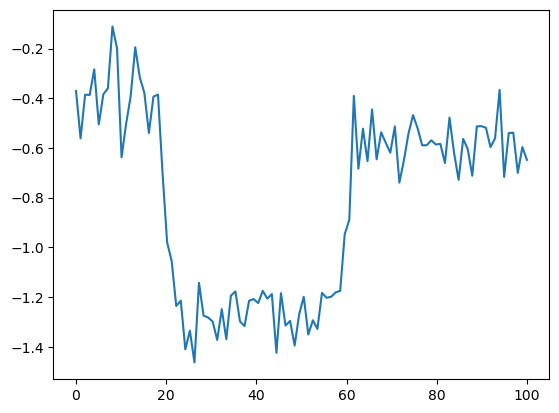

In [3]:
data = np.load("data.npz")
X, y = data["X"], data["y"]
D = gpx.Dataset(X=X, y=y)
plt.plot(X, y)

### Define (conjugate) model, priors

In [30]:
kernel = ChangePoints(kernels=[gpx.kernels.RBF(), gpx.kernels.RBF()], locations=[50], steepness=[1])
#kernel = gpx.kernels.RBF(lengthscale=2)
meanf = gpx.mean_functions.Constant(1)
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)

posterior = prior * likelihood
graphdef, params, *static_state = nnx.split(posterior, gpx.parameters.Parameter, ...)
# prior_dict = {"prior": {"kernel": {"variance": tfd.Gamma(1, 1), "lengthscale": tfd.Gamma(1, 1)},  # Uncomment for regular RBF kernel
#                         "mean_function": {"constant": tfd.Normal(0, 10)}}, "likelihood": {"obs_stddev": tfd.LogNormal(1, 1)}}
#              # "latent": tfd.Normal(0, 1)}   # and replace likelihood with this for NonConjugate case

prior_dict = {"prior": {"kernel": {"kernels": {0: {"variance": tfd.LogNormal(0, 1), "lengthscale": tfd.LogNormal(1, 1)},
                                               1: {"variance": tfd.LogNormal(0, 1), "lengthscale": tfd.LogNormal(1, 1)}},
                                    "locations": tfd.Uniform(0, len(X)),
                                    "steepness": tfd.Uniform(0, 10)},
                        "mean_function": {"constant": tfd.Normal(0, 1)}},
                        "likelihood": {"obs_stddev": tfd.LogNormal(1, 1)}}

posterior = set_priors(posterior, prior_dict)
graphdef, params, *static_state = nnx.split(posterior, gpx.parameters.Parameter, ...)
param_dim = sum([p.size for p in jtu.tree_flatten(params)[0]])


In [31]:
mesh = jax.sharding.Mesh(devices=np.array(jax.devices()).reshape(1, 4),
            axis_names=('data', 'model'))

ValueError: cannot reshape array of size 8 into shape (1,4)

In [32]:
@nnx.jit
def create_sharded_model(particle_list):
  model = particle_list # Unsharded at this moment.
  state = nnx.state(model)                   # The model's state, a pure pytree.
  pspecs = nnx.get_partition_spec(state)     # Strip out the annotations from state.
  sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
  nnx.update(model, sharded_state)           # The model is sharded now!
  return model

with mesh:
  particle_list = init_particles(posterior, 100, key)
  particle_list = create_sharded_model(particle_list)
 
jax.debug.visualize_array_sharding(particle_list.prior.kernel.locations.value)

                   
                   
                   
                   
                   
CPU 0,1,2,3,4,5,6,7
                   
                   
                   
                   
                   

In [33]:
data_sharding = NamedSharding(mesh, PartitionSpec('data', None))
X = jax.device_put(X, data_sharding)
y = jax.device_put(y, data_sharding)

jax.debug.visualize_array_sharding(X)
jax.debug.visualize_array_sharding(y)

                   
                   
                   
                   
                   
CPU 0,1,2,3,4,5,6,7
                   
                   
                   
                   
                   

                   
                   
                   
                   
                   
CPU 0,1,2,3,4,5,6,7
                   
                   
                   
                   
                   

In [ ]:
with mesh:
    params_bijection = gpx.parameters.DEFAULT_BIJECTION
    graphdef, params, *static_state = nnx.split(particle_list, nnx.VariableState, ...)
    params = gpx.parameters.transform(params, params_bijection, inverse=True)
    key, smc_key = jr.split(key)

    t = datetime.now()
    print(t)
    final_state = smc(params, D, graphdef, ess=0.9, integration_steps=20, mcmc_steps=1)
    params = gpx.parameters.transform(final_state.particles, params_bijection)
    final_particles = nnx.merge(graphdef, final_state.particles)  
    dt = datetime.now() - t
    print("Sampling took", dt.total_seconds())

2025-04-01 17:24:41.876748
N_PART 100


KeyboardInterrupt: 

If we do not take that many MCMC steps, we don't find much, unfortunately:

In [ ]:
def tree_untranspose(tree_of_lists):
    """
    Chat'd.
    Converts a single tree of lists into a list of trees with the original structure.
    Handles JAX TracedArrays and works dynamically with shapes.
    """
    leaves = jtu.tree_leaves(tree_of_lists)

    # Ensure there is at least one leaf
    if not leaves:
        raise ValueError("Empty tree provided to tree_untranspose.")

    # Use JAX to infer the number of trees from the first leaf.
    # We rely on lax to safely handle dynamic shape evaluation.
    def get_shape(x):
        # For TracedArrays (during JIT), use jax.lax to safely extract shape
        return x.shape[0] if hasattr(x, 'shape') else len(x)

    # Get the length of the first leaf (it should be the same for all leaves)
    num_trees = get_shape(leaves[0])

    # Reconstruct the trees by indexing each element in the leaves
    return [jtu.tree_map(lambda lst: lst[i], tree_of_lists) for i in range(num_trees)]

In [ ]:
particles = tree_untranspose(final_state.particles)

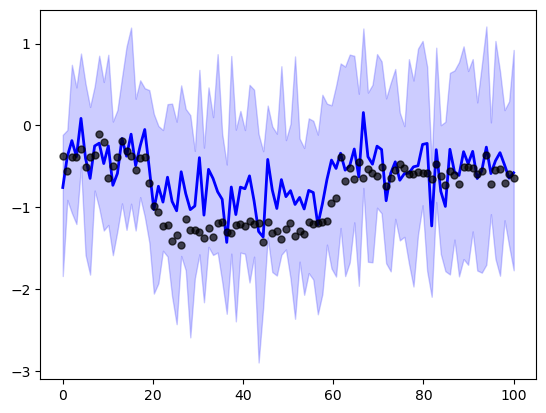

In [ ]:
posterior_samples = []
xtest = jnp.linspace(0, 100, 100).reshape(-1, 1)
for i in range(0, N_particles, 500):
    sample_params = particles[i]
    sample_params = gpx.parameters.transform(sample_params, params_bijection)
    model = nnx.merge(graphdef, sample_params, *static_state)
    latent_dist = model.predict(xtest, train_data=D)
    predictive_dist = model.likelihood(latent_dist)
    posterior_samples.append(predictive_dist.sample(seed=key, sample_shape=(10,)))

posterior_samples = jnp.vstack(posterior_samples)
lower_ci, upper_ci = jnp.percentile(posterior_samples, jnp.array([2.5, 97.5]), axis=0)
expected_val = jnp.mean(posterior_samples, axis=0)
fig, ax = plt.subplots()
ax.plot(
    D.X, D.y, "o", markersize=5, color="black", label="Observations", zorder=2, alpha=0.7
)
ax.plot(
    xtest, expected_val, linewidth=2, color="blue", label="Predicted mean", zorder=1
)
ax.fill_between(
    xtest.flatten(),
    lower_ci.flatten(),
    upper_ci.flatten(),
    alpha=0.2,
    color="blue",
    label="95% CI",
)
plt.show()

<Axes: ylabel='Density'>

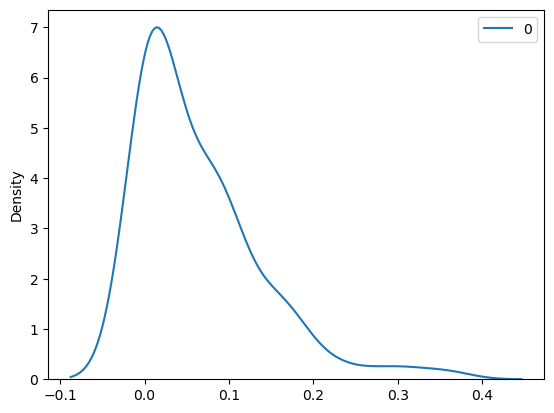

In [ ]:
locs = (final_particles.prior.kernel.locations.value)
sns.kdeplot(locs)